In [63]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
import torchvision.datasets as datasets
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader

import sys
sys.path.append('./python_files/')
from model_trainer import ModelTrainer
from utils import *
from data_loader import load_data, generate_dataset_g
from nn_modules import View
from nn_models import LeNet, aliG

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
print("pytorch version: ",torch.__version__)

pytorch version:  0.5.0a0


In [65]:
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print("Using GPU: ",torch.cuda.get_device_name(0))

Using GPU:  GeForce GTX 1080 Ti


## Loading the data (MNIST)

In [66]:
train_input, train_target, test_input, test_target = load_data(cifar=False, normalize=True, flatten=False, full=False)

train_target = train_target.long()
test_target = test_target.long()

* Using MNIST
** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples


In [67]:
print("# of training samples : "+str(len(train_input)))

# of training samples : 1000


In [68]:
train_target[0].type()

'torch.cuda.LongTensor'

## 1) LeNet with disjoint trainset and testset

In [69]:
train_dataset = (train_input, train_target)
test_dataset = (test_input, test_target)

In [70]:
crossEntropyClassesWeigths = computeClassesWeights(train_target)

******************************** Train log ************************************
                     train loss       train acc        val loss         val acc
0                    0.02175159           0.271      0.00201506           0.306
10                   0.00238822           0.920      0.00074812           0.754
20                   0.00046369           0.990      0.00023213           0.927
30                   0.00015046           1.000      0.00022729           0.922
40                   0.00006740           1.000      0.00022356           0.927
49                   0.00004448           1.000      0.00022356           0.931
*******************************************************************************


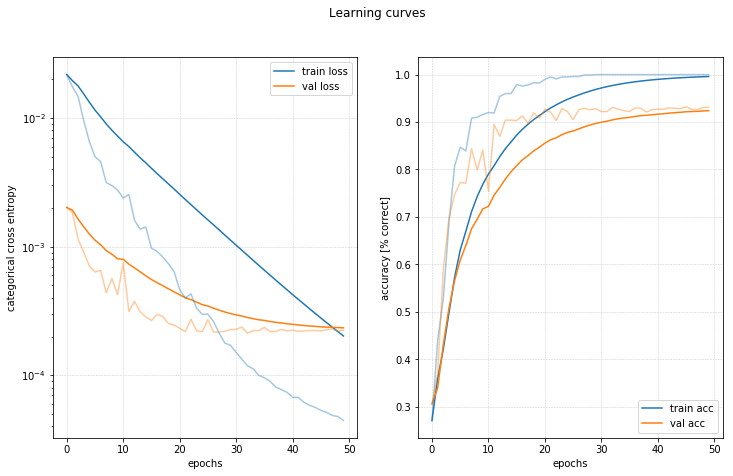

In [71]:
model = LeNet()

crit_fun = lambda input_, target : (input_, target)
y_hat_fun = lambda y: y.argmax(1)

loss_fun = nn.CrossEntropyLoss(weight=crossEntropyClassesWeigths)
learning_rate = 0.08

mt = ModelTrainer(model, loss_fun, optim.SGD(model.parameters(), lr=learning_rate), y_hat_fun, crit_fun)
hist = mt.fit(train_dataset, test_dataset, epochs=50, batch_size=100, verbose=10)
mt.plot_training("Learning curves")

## 2) Extract layers activations examples

In [72]:
model.eval()

LeNet(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=10, bias=True)
)

In [73]:
#Can use the handle to remove the hook, don't execute twice on 
#the same handle, or you won't be able to remove the first
#instance of the hook
output_d, handles_d  = spyOn([model.conv2, model.fc1], ['convolution 2', 'FC_1'], True)

In [74]:
model(train_input[0:10].reshape(-1, 1, 28, 28))

captured output at layer : Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
captured output at layer : Linear(in_features=256, out_features=200, bias=True)


tensor([[ -1.1261,   0.2319,  -2.2108,   8.2289,  -8.8106,  13.9956,  -5.1217,
          -4.9852,   4.3573,  -1.5158],
        [ 16.1048,  -5.2382,   1.3853,  -3.6267,  -7.9822,   2.5762,   1.2530,
           1.2929,  -5.4332,   3.9208],
        [ -6.9658,  -0.2990,   3.6982,   1.3166,  12.7887,  -3.0896,  -2.0600,
           2.0811,  -5.5891,   3.5318],
        [ -4.2202,  16.6430,   5.7847,  -4.7326,  -0.7825,  -9.9602,  -1.6584,
           4.1487,   3.8827,  -6.1504],
        [ -7.4407,  -1.0903,  -3.7515,  -1.2637,   7.1777,  -2.8158,  -7.9753,
           2.3371,   5.4118,  16.4798],
        [  1.9087,  -3.1865,  11.0889,   2.2133,  -8.3201,  -1.6184,  -2.6984,
           0.3635,   4.1818,   1.9694],
        [ -7.7393,  11.7036,   2.5693,  -0.2030,  -0.7769,  -1.3100,   0.1971,
           0.0766,   3.9108,  -2.7437],
        [ -0.8917,  -4.6641,   4.4691,  19.9583, -11.5973,   3.9280, -12.2253,
          -2.5459,   6.0714,   3.7880],
        [ -6.5266,  11.3777,   0.5818,  -2.0877,

In [75]:
output_d['convolution 2'].reshape(10, -1).shape

torch.Size([10, 1024])

In [76]:
remove_spying(handles_d)

## 3) Differentiate layer activation from training sample than one from a testing sample

In [91]:
model.eval()

LeNet(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=10, bias=True)
)

In [92]:
layer = model.fc1
layer_name = "fc1"

In [93]:
(g_train_input, g_train_target), (g_test_input, g_test_target) = \
generate_dataset_g(model, train_dataset, test_dataset, [layer], [layer_name], split=0.7)

g_train_target = g_train_target.long()
g_test_target = g_test_target.long()

g_train_dataset = (g_train_input, g_train_target)
g_test_dataset = (g_test_input, g_test_target)  

In [94]:
size_input_vector = g_train_dataset[0].shape[2]
print("size of layer vector :", size_input_vector)

size of layer vector : 200


******************************** Train log ************************************
                     train loss       train acc        val loss         val acc
0                    0.00693806           0.500      0.00115484           0.500
10                   0.00646031           0.637      0.00102885           0.680
20                   0.00582259           0.719      0.00105432           0.667
30                   0.00567282           0.731      0.00104720           0.677
40                   0.00555658           0.744      0.00109187           0.645
50                   0.00517241           0.789      0.00108315           0.638
60                   0.00530121           0.774      0.00111472           0.630
70                   0.00514567           0.796      0.00112825           0.620
80                   0.00474533           0.834      0.00111498           0.635
90                   0.00485572           0.821      0.00107752           0.658
100                  0.00470360         

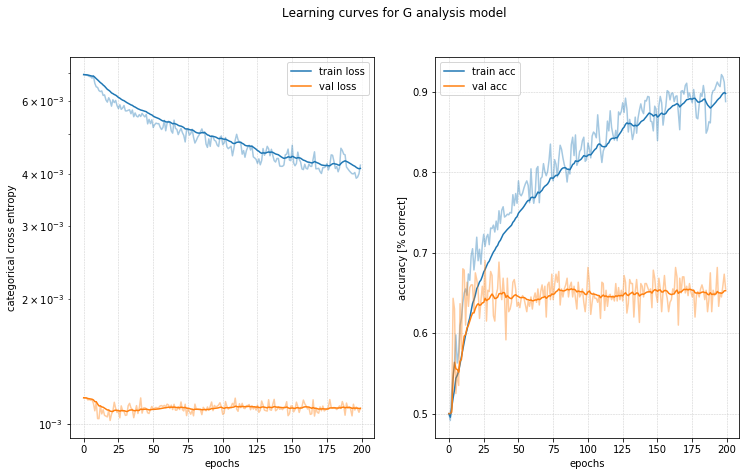

In [96]:
modelG = aliG(size_input_vector)

crit_fun = lambda input_, target : (input_, target)
y_hat_fun = lambda y: y.argmax(1)

loss_fun = nn.CrossEntropyLoss()
learning_rate = 1

mt = ModelTrainer(modelG, loss_fun, optim.SGD(modelG.parameters(), lr=learning_rate), y_hat_fun, crit_fun)
hist = mt.fit(g_train_dataset, g_test_dataset, epochs=200, batch_size=100, verbose=10)
mt.plot_training("Learning curves for G analysis model")